# Data to Strategy with Alpaca
Query and process Alpaca OHLCV data. Add features, identify principal components and develop initial trade algorithm.
    
https://github.com/emskiphoto/Alpaca-Strategy-Development<BR>
Copyright 2021 Matt Chmielewski

#### References:
http://localhost:8888/notebooks/ML4T/source/08_ml4t_workflow/04_ml4t_workflow_with_zipline/03_ml4t_with_zipline.ipynb
http://localhost:8888/notebooks/ML4T/source/02_market_and_fundamental_data/01_NASDAQ_TotalView-ITCH_Order_Book/03_normalize_tick_data.ipynb

### Load Dependencies

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
# from alpaca_trade_api.rest import TimeFrame - Won't work 6-11-21
from datetime import datetime, timedelta
import timeit
from alpaca_trade_api.rest import REST
# from alpaca_trade_api.rest import TimeFrame
# Disable jedi autocompleter
%config Completer.use_jedi = False

In [2]:
pd.options.display.max_rows = 300
#     create idx for mutlti-index slicing
idx = pd.IndexSlice

### Check connection to Alpaca

#### Verify Windows Environment Variables are available
API Credentials are stored on Windows PATH variable.  https://dev.to/biplov/handling-passwords-and-secret-keys-using-environment-variables-2ei0

In [3]:
API_credential_vars = ['APCA_API_BASE_URL','APCA_API_KEY_ID', 'APCA_API_SECRET_KEY']
# for var in API_credential_vars:
#     print(os.getenv(var))

### Check Alpaca account

In [4]:
api = tradeapi.REST()
# Get our account information.
account = api.get_account()
# Check if our account is restricted from trading.
if account.trading_blocked:
    print('Account is currently restricted from trading.')
# Check how much money we can use to open new positions.
print('${} is available as buying power.'.format(account.buying_power))

$184728.34 is available as buying power.


### Download Price History

#### Get list of assets

In [5]:
def build_asset_df_alpaca(api, status='active'):
    """Returns a list of assets and trading characteristics as a dataframe"""
    assets = api.list_assets(status=status)
    return pd.DataFrame.from_records([asset._raw for asset in assets.__iter__()])
df_assets = build_asset_df_alpaca(api)
df_assets.head(2)

id      class exchange symbol  \
0  1dfc8a4a-39c5-471e-a8b4-77945a60bd94  us_equity   NASDAQ   KALA   
1  bf9e9dc8-35c8-4611-8687-af42bae92936  us_equity   NASDAQ   LOTZ   

                                      name  status  tradable  marginable  \
0  Kala Pharmaceuticals, Inc. Common Stock  active      True        True   
1       CarLotz, Inc. Class A Common Stock  active      True        True   

   shortable  easy_to_borrow  fractionable  
0      False           False         False  
1       True            True         False

In [6]:
df_assets.groupby(['exchange','marginable']).count().iloc[:,:2]

id  class
exchange marginable             
AMEX     True         262    262
ARCA     True        1800   1800
BATS     True         532    532
NASDAQ   False          1      1
         True        4745   4745
NYSE     True        2957   2957
OTC      True           5      5

In [7]:
df_assets['class'].value_counts()

us_equity    10302
Name: class, dtype: int64

## Build OHLCV Database
https://alpaca.markets/docs/api-documentation/api-v2/market-data/alpaca-data-api-v2/

### Iteratively build database

#### Set list of Assets

In [13]:
print(f'There are {df_assets["symbol"].nunique()} assets total')
# assets_query = df_assets['symbol'].sample(10).sort_values().to_list()
assets_query = df_assets['symbol'][:100].sort_values().to_list()
print(f'There are {len(assets_query)} assets in assets_query')
assets_query[:10]

There are 10302 assets total
There are 100 assets in assets_query


['APSG', 'ASM', 'ASMB', 'KALA', 'KALL', 'KALU', 'KALV', 'KAMN', 'KAPR', 'KAR']

The rate limit is 200 requests every minute per API key.<BR>
All date time type inputs and outputs are serialized according to ISO8601<BR>


### Query multiple assets - store in single df

In [14]:
def build_multi_symbol_df(assets,start_date = '2021-01-01', end_date = '2021-05-25',
                            frequency='15Min', TZ = 'America/New_York', limit=1000):
    """Returns single multi-index OHLCV time series dataframe for list of assets over input time
    range using Alpaca's API 'get_barset()' method.  'assets' must be input as list.
    Output multi-index is:  symbol, timestamp
    and output columns are: open, high, low, close, volume.
   
    frequency options:
    Day = "1Day"
    Hour = "1Hour"
    15 Minute = '15Min'
    Minute = "1Min"
    Sec = "1Sec"
    
    """
#     reference problematic query (missing bars - not used here):
# TZ = 'America/New_York'
# bars = api.get_barset('AAQC.U', '5Min',
#                           end=pd.Timestamp('2021-05-19', tz=TZ).isoformat(),
#                           limit=1000).df.droplevel(0,axis=1)
# Sort assets for the benefit of future indexing
    assets = sorted(assets)
# Get Name of columns for temp df
    n_assets = len(assets)
    print(f'{n_assets} total assets to query')
    start_date_plus_1 = datetime.strftime(datetime.strptime(start_date,"%Y-%m-%d") + timedelta(days=10),"%Y-%m-%d" )
#     Build empty DataFrame
# Get names of columns based on short query of first asset
    columns = list(api.get_barset(assets[0], frequency,
        start=start_date, end=start_date_plus_1).df.droplevel(0,axis=1).columns)
#     Create empty dataframe as multiindex to hold bars responses
    temp = pd.DataFrame(columns=['symbol',
             'timestamp'] + columns).set_index(['symbol','timestamp']).asfreq(frequency)
    bars_ = []
    bars = []

#     Set dates
    end_date_range = pd.to_datetime(pd.Timestamp(end_date, tz=TZ).isoformat())
    start_date_dt = pd.to_datetime(pd.Timestamp(start_date, tz=TZ).isoformat())
    print(start_date_dt, "\n", end_date_range)
# Iterate through assets:
    for idx, symbol in enumerate(assets):
#         update start_date_dt
        print(f'== {idx + 1} of {n_assets} querying "{symbol}" from {start_date_dt} to {end_date_range} ==')
#       
        #         limit date range to not exceed API's bars limit
        count = 0
        end_date_dt = end_date_range
        last_index_start = end_date_range
        while end_date_dt.to_pydatetime() >= start_date_dt.to_pydatetime():
            count+=1
            print(f'Chunk {count} - {symbol} desired end date:  {end_date_dt}')
#             print(f'end Date is: {end_date_dt}')
# Chunked query starts with end date and works backwards in time to start date
            bars = api.get_barset(symbol, frequency,
                                  end=end_date_dt.isoformat(),
                                  limit=limit).df.droplevel(0,axis=1)

            print(f'Bars shape:  {bars.shape}')
#     Check if bars is empty, if so break out of loop
            try:
                bars.index[0]
            except:
                break
#     Break out of loop if start date repeats (indicating no history prior to start date available)
            if bars.index[0].to_pydatetime() == last_index_start:
                print(f'<<<<<  No history prior to {last_index_start} available for {symbol}  >>>>>\n\n')
                break
            last_index_start = bars.index[0].to_pydatetime()
            print(f'{symbol} chunk {count} index start:  {bars.index[0]}')
#             print(f'Start of barset index {bars.index[0]}')
            print(f'{symbol} chunk {count} index end:   {bars.index[-1]}')
# If an empty 'bars' is returned, skip to next asset
            if len(bars.index) < 1:
                break
            
#             end of date range based on chunk size:
# For testing:
#             start_date_dt = datetime.strptime(start_date_str,"%Y-%m-%d") + timedelta(days=10)

#             Reset chunk end date to be one period before the start of the last chunk that was queried
            end_date_dt = pd.Timestamp(bars.index[0]) - pd.Timedelta(frequency)
            print(f'Is {end_date_dt.to_pydatetime()} less than {start_date_dt.to_pydatetime()}'
                  f': {end_date_dt.to_pydatetime() < start_date_dt.to_pydatetime()}\n')
#     slice off records with dates outside of input start and end dates and set index frequency of df
#             bars = bars.loc[start_date:end_date]
#             bars = bars.loc[start_date:end_date]
            bars = bars.loc[start_date:end_date].asfreq(frequency).sort_index()
#             print(bars.index)
#     Create multi-index as list of tuples
            unique_timestamps = bars.index.unique()
            idx_tuples = [(symbol,timestamp) for timestamp in unique_timestamps]
#             idx_tuples = [(symbol,timestamp) for timestamp in bars.index]
            bars.set_index(pd.Index(idx_tuples), inplace=True)
            bars.rename_axis(['symbol','timestamp'], inplace=True)
            bars_.append(bars)
        
#         #     Drop duplicate indices, if needed
#         unique_idx = bars_.index.drop_duplicates(keep='first')
#         bars_ = bars.loc[unique_idx]
        
# completed compiling bars_, now commit to dataframe
    df = pd.concat([temp] + bars_)
#     set frequency of datetime index
    df.index.levels[1].freq = frequency
# If there is a volume column fill any NaN and convert to integer
    if 'volume' in df.columns:
#         df['volume'] = df['volume'].interpolate().astype('int')
        df['volume'] = df['volume'].astype('int', errors='ignore')
#     df.index = df.index.tz_convert('America/New_York')
# Sort symbols and timestamps alphabetically and chronologically
#     df.sort_index(level=['symbol','timestamp'], inplace=True)
#     remove records where OHLC are all NaN
    df = df.dropna(subset=['open','high','low','close'], how='all')

    return df
    del bars_, df


### Query assets

#### Asset query parameters
In the future, implement a 'class' to manage attributes of queries

In [15]:
frequency = '15Min'
start_date = '2020-01-01'
end_date = '2021-05-30'
TZ = 'America/New_York'

In [16]:
%timeit
# list of particularly messy symbols:
test_list = ['ACSI', 'AHT', 'TMAT', 'AROC', 'BBUS', 'CAT','AMAM']
# df = build_multi_symbol_df(assets_query[:10],start_date = '2020-01-01', end_date = '2021-05-25',
#                           frequency='5Min', TZ = 'America/New_York', limit=1000)
df = build_multi_symbol_df(test_list,start_date = start_date, end_date = end_date,
                          frequency=frequency, TZ = TZ, limit=1000)

7 total assets to query
2020-01-01 00:00:00-05:00 
 2021-05-30 00:00:00-04:00
== 1 of 7 querying "ACSI" from 2020-01-01 00:00:00-05:00 to 2021-05-30 00:00:00-04:00 ==
Chunk 1 - ACSI desired end date:  2021-05-30 00:00:00-04:00
Bars shape:  (348, 5)
ACSI chunk 1 index start:  2016-11-01 12:45:00-04:00
ACSI chunk 1 index end:   2021-02-26 12:15:00-05:00
Is 2016-11-01 12:30:00-04:00 less than 2020-01-01 00:00:00-05:00: True

== 2 of 7 querying "AHT" from 2020-01-01 00:00:00-05:00 to 2021-05-30 00:00:00-04:00 ==
Chunk 1 - AHT desired end date:  2021-05-30 00:00:00-04:00
Bars shape:  (1000, 5)
AHT chunk 1 index start:  2021-04-07 15:45:00-04:00
AHT chunk 1 index end:   2021-05-28 15:45:00-04:00
Is 2021-04-07 15:30:00-04:00 less than 2020-01-01 00:00:00-05:00: False

Chunk 2 - AHT desired end date:  2021-04-07 15:30:00-04:00
Bars shape:  (1000, 5)
AHT chunk 2 index start:  2021-02-11 10:00:00-05:00
AHT chunk 2 index end:   2021-04-07 15:30:00-04:00
Is 2021-02-11 09:45:00-05:00 less than 2020

Bars shape:  (1000, 5)
CAT chunk 10 index start:  2019-11-15 15:30:00-05:00
CAT chunk 10 index end:   2020-01-17 11:15:00-05:00
Is 2019-11-15 15:15:00-05:00 less than 2020-01-01 00:00:00-05:00: True

== 7 of 7 querying "TMAT" from 2020-01-01 00:00:00-05:00 to 2021-05-30 00:00:00-04:00 ==
Chunk 1 - TMAT desired end date:  2021-05-30 00:00:00-04:00
Bars shape:  (203, 5)
TMAT chunk 1 index start:  2021-01-29 10:15:00-05:00
TMAT chunk 1 index end:   2021-05-12 15:15:00-04:00
Is 2021-01-29 10:00:00-05:00 less than 2020-01-01 00:00:00-05:00: False

Chunk 2 - TMAT desired end date:  2021-01-29 10:00:00-05:00
Bars shape:  (0, 5)


#### Save df to disk

In [14]:
# df.to_csv(f'data/{df.index.levels[0].nunique()}_symbols_{start_date}_to_{end_date}_raw.csv')

#### Was full time range of data queried?

In [17]:
start_date == datetime.strftime(df.index.levels[1].min(), "%Y-%m-%d")

False

In [18]:
end_date == datetime.strftime(df.index.levels[1].max(), "%Y-%m-%d")

False

In [19]:
start_date, df.index.levels[1].min(), end_date, df.index.levels[1].max()

('2020-01-01',
 Timestamp('2020-01-02 09:30:00-0500', tz='America/New_York', freq='15T'),
 '2021-05-30',
 Timestamp('2021-05-28 15:45:00-0400', tz='America/New_York', freq='15T'))

#### Are there gaps in the dates or times of the time series?

In [26]:
symbols_by_close_count = df.groupby(level=0).count().sort_values(by='close').index

In [29]:
df.loc[idx[symbols_by_close_count[0],:]].head(6)

open   high    low  close  volume
timestamp                                                    
2020-02-25 15:45:00-05:00  35.27  35.27  35.27  35.27   100.0
2020-03-13 11:15:00-04:00  27.84  27.84  27.84  27.84   100.0
2020-03-18 13:45:00-04:00  25.58  25.58  25.58  25.58   100.0
2020-07-18 08:00:00-04:00  34.86  35.02  34.86  34.96   500.0
2020-07-18 08:15:00-04:00  34.96  35.00  34.80  35.00   800.0
2020-07-18 08:30:00-04:00  34.94  35.01  34.88  34.88   600.0

In [36]:
df.loc[idx[symbols_by_close_count[1],:]].head(6)

open    high     low   close  volume
timestamp                                                        
2021-01-29 10:15:00-05:00  24.995  24.995  24.995  24.995   400.0
2021-02-01 11:45:00-05:00  24.940  24.940  24.940  24.940   300.0
2021-02-01 12:00:00-05:00  24.960  24.960  24.960  24.960   403.0
2021-02-01 12:30:00-05:00  25.010  25.010  25.010  25.010   200.0
2021-02-01 13:00:00-05:00  25.050  25.050  25.050  25.050   110.0
2021-02-01 13:45:00-05:00  25.060  25.060  25.060  25.060   230.0

#### How many rows of data does each symbol have?

In [41]:
df.groupby(level=0).count().sort_values(by='close')['close'].head(10)

symbol
ACSI      33
TMAT     203
BBUS     375
AHT     8532
AROC    9015
CAT     9294
Name: close, dtype: int64

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 27452 entries, ('ACSI', Timestamp('2020-02-25 15:45:00-0500', tz='America/New_York', freq='15T')) to ('TMAT', Timestamp('2021-05-12 15:15:00-0400', tz='America/New_York', freq='15T'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    27452 non-null  float64
 1   high    27452 non-null  float64
 2   low     27452 non-null  float64
 3   close   27452 non-null  float64
 4   volume  27452 non-null  float64
dtypes: float64(5)
memory usage: 1.6+ MB


### Clean & Filter data

#### Infer market days and market hours from df
Data supplied contains market and after hours data. Identifying market days and market hours enables segregation of market and non-market hours data.

In [43]:
def aggregate_daily_trade_count_from_df(df, n_symbols=5, min_trade_count_pct = 0.025):
    """Returns numerical indices for only df records containing dates with measurable market activity
    (df record count > min_trade_count_pct).  
    n_symbols: the minimum number of symbols in the df
    that are considered out of all symbols in df.
    min_trade_count_pct:  the minimum normalized count percentage of historical trades (i.e. total
    aggregated trade count for a given hour divided my max trade count of any hour) needed
    to distinguish low volume trading hours (i.e. outside market hours) from high volume
    trading hours"""
#     create idx for mutlti-index slicing
    idx = pd.IndexSlice
#     find symbols with highest rates of complete data
    symbols = df.index.get_level_values(0).unique().to_list()
    counts = [df.loc[idx[symbol,:],'close'].count() for symbol in symbols]
    lengths = [df.loc[idx[symbol,:],'close'].shape[0] for symbol in symbols]
    pct_completes = [count/length for count, length in zip(counts, lengths)]
#     obtain indices of largest pct_completes values, then analyze top n symbols 
    pct_ranked_idx = sorted(range(len(pct_completes)), key=lambda x: pct_completes[x],reverse=True)
    analysis_symbols = [symbols[x] for x in pct_ranked_idx][:min(n_symbols,len(symbols))]
#     Get aggregate count of transactions by hour of day then normalize values
    agg_trade_count_by_day = df.loc[idx[analysis_symbols,:],'close']\
        .groupby(df.loc[idx[analysis_symbols,:],'close'].index.get_level_values(1).date).count()
    return agg_trade_count_by_day

In [44]:
agg_trade_count_by_day = aggregate_daily_trade_count_from_df(df, n_symbols=5, min_trade_count_pct = 0.025)
agg_trade_count_by_day

2020-01-02    77
2020-01-03    78
2020-01-06    78
2020-01-07    78
2020-01-08    79
              ..
2021-05-24    80
2021-05-25    78
2021-05-26    75
2021-05-27    73
2021-05-28    78
Name: close, Length: 357, dtype: int64

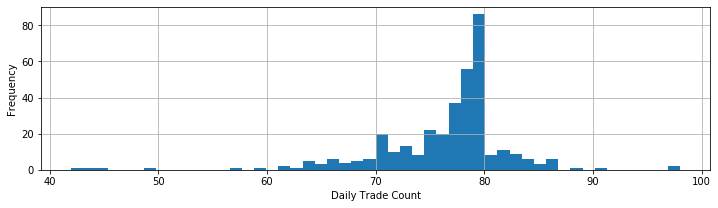

In [51]:
# agg_trade_count_by_day.plot(kind='bar',figsize=(12,5))
agg_trade_count_by_day.plot(kind='hist', bins=50,figsize=(12,3), grid='both')
plt.xlabel('Daily Trade Count')
plt.show()

In [52]:
def market_days_from_df(agg_trade_count_by_day):
    """Function assumes any dates missing in input df are days where the 
    market is closed.  Returns datetime series of market days"""
    return pd.to_datetime(agg_trade_count_by_day.index)

In [53]:
market_dates = market_days_from_df(agg_trade_count_by_day)

In [54]:
market_dates

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2021-05-17', '2021-05-18', '2021-05-19', '2021-05-20',
               '2021-05-21', '2021-05-24', '2021-05-25', '2021-05-26',
               '2021-05-27', '2021-05-28'],
              dtype='datetime64[ns]', length=357, freq=None)

### Determine Market Hours from source data

In [55]:
def infer_market_hours_from_df(df, n_symbols=5, min_trade_count_pct = 0.2):
    """Returns 'market_open' and 'market_close' from multi-index df containing full-day 
    time-series data.  
    n_symbols: the minimum number of symbols in the df
    that are considered out of all symbols in df.
    min_trade_count_pct:  the minimum normalized count percentage of historical trades (i.e. total
    aggregated trade count for a given hour divided my max trade count of any hour) needed
    to distinguish low volume trading hours (i.e. outside market hours) from high volume
    trading hours"""
#     create idx for mutlti-index slicing
    idx = pd.IndexSlice
#     find symbols with highest rates of complete data
    symbols = df.index.get_level_values(0).unique().to_list()
    counts = [df.loc[idx[symbol,:],'close'].count() for symbol in symbols]
    lengths = [df.loc[idx[symbol,:],'close'].shape[0] for symbol in symbols]
    pct_completes = [count/length for count, length in zip(counts, lengths)]
#     obtain indices of largest pct_completes values, then analyze top n symbols 
    pct_ranked_idx = sorted(range(len(pct_completes)), key=lambda x: pct_completes[x],reverse=True)
    analysis_symbols = [symbols[x] for x in pct_ranked_idx][:min(n_symbols,len(symbols))]
#     Get aggregate count of transactions by hour of day then normalize values
    agg_trade_count_by_time = df.loc[idx[analysis_symbols,:],'close']\
        .groupby(df.loc[idx[analysis_symbols,:],'close'].index.get_level_values(1).time).count()
    max_count = agg_trade_count_by_time.max()
    normed_agg_trade_count_by_time = agg_trade_count_by_time/max_count
    # Identify first and last hour where aggregate transaction count > min_trade_count_pct
    times_w_count_gt_threshold = [idx for idx in normed_agg_trade_count_by_time.index if normed_agg_trade_count_by_time[idx] > min_trade_count_pct  ]
    market_open, market_close = times_w_count_gt_threshold[0],times_w_count_gt_threshold[-1]
    return market_open, market_close


In [56]:
market_open, market_close = infer_market_hours_from_df(df, n_symbols=10)
market_open, market_close

(datetime.time(9, 30), datetime.time(15, 45))

#### Create a perfect, complete datetime index to reindex raw data

In [57]:
datetime_idx_complete = pd.date_range(start=df.index.levels[1].min(), end=df.index.levels[1].max(), freq=df.index.levels[1].freq)
datetime_idx_complete

DatetimeIndex(['2020-01-02 09:30:00-05:00', '2020-01-02 09:45:00-05:00',
               '2020-01-02 10:00:00-05:00', '2020-01-02 10:15:00-05:00',
               '2020-01-02 10:30:00-05:00', '2020-01-02 10:45:00-05:00',
               '2020-01-02 11:00:00-05:00', '2020-01-02 11:15:00-05:00',
               '2020-01-02 11:30:00-05:00', '2020-01-02 11:45:00-05:00',
               ...
               '2021-05-28 13:30:00-04:00', '2021-05-28 13:45:00-04:00',
               '2021-05-28 14:00:00-04:00', '2021-05-28 14:15:00-04:00',
               '2021-05-28 14:30:00-04:00', '2021-05-28 14:45:00-04:00',
               '2021-05-28 15:00:00-04:00', '2021-05-28 15:15:00-04:00',
               '2021-05-28 15:30:00-04:00', '2021-05-28 15:45:00-04:00'],
              dtype='datetime64[ns, America/New_York]', length=49174, freq='15T')

#### Are there duplicate timestamps within a given symbol's index?

In [58]:
def check_for_duplicated_dt_indices(df):
    print('Does symbol have duplicated timestamps in datetime index?')
    symbol_dt_index_duplicated = []
    duplicated_dt_index = {}
    symbols = df.index.get_level_values(0).unique()
    for symbol in symbols:
        duplicated_dt_index = df.loc[idx[symbol,:]].index.has_duplicates
        print(f'{symbol}: {duplicated_dt_index}')    
        symbol_dt_index_duplicated.append(duplicated_dt_index)
    duplicated_dt_index = dict(zip(symbols,symbol_dt_index_duplicated ))
    return duplicated_dt_index

In [59]:
duplicated_dt_index = check_for_duplicated_dt_indices(df)

Does symbol have duplicated timestamps in datetime index?
ACSI: False
AHT: False
AROC: False
BBUS: False
CAT: False
TMAT: False


### Fill gaps in datetime index

In [60]:
# just in case....
df_backup = df.copy()
# df = df_backup.copy()

In [61]:
def fill_OHLCV_gaps(df):
    """Returns complete time series from input OHLCV time series dataframe.
    Input dataframe must have timezone aware datetime index with a defined 
    frequency and can be single or dual indexed (ex. ['symbol', 'timestamp']).   
    NaN records leading up to first non-NaN record are returned unaltered.
    
    The OHLC data 
    is forward filled and NaNs in the volume data should be filled
    with '0'. This is because NaNs in price data should carry forward the
    last prices - the assumption is that if there are no new transactions 
    (i.e. volume = 0) then the most recent valid price is also the current
    valid price. Volume NaNs should be filled with '0' because if there were
    no prices or volume reported for a given timestamp it means there was no volume.
    Goal is to revise time series so that no records are NaN in the time series and
    no timestamp gaps in the time series sequence."""
    
    OHLC_cols = ['open','high','low','close']
    
    def process_df(df, symbol, datetime_idx_complete):
        """Different fill logic is needed for OHLC and volume data. 
        The OHLC data should be forward filled and NaNs in the volume
        data should be filled with '0'. This is because NaNs in price
        data should carry forward the last prices - the assumption is
        that if there are no new transactions (volume = 0) than the most 
        recent valid price is also the current valid price. Volume NaNs 
        should be filled with '0' because if there were no prices or volume
        reported for a given timestamp it means there was no volume.
        
        Leading NaN OHLC records with 0 volume remain NaN - that is OK as 
        we don't want to back fill leading NaNs.  It's better to not have 
        the data and omit the first n records than to force assumed values 
        on leading data.

        It can be seen that OHLC prices for 0-volume intervals are not NaN 
        and remain constant over intervals until volume > 0 - this is good.  """
    #             create df single index df and reindex to achieve complete datetime index
        df = df.reindex(datetime_idx_complete)
#                 fill NaN in volume columns with 0

        df['volume'] = df['volume'].fillna(0) 
#                 forward fill OHLC columns
        df[OHLC_cols] = df[OHLC_cols].ffill()
        return df
        
#     check if df is a multi-index
    is_multi_idx = isinstance(df.index, pd.MultiIndex)
    
    if is_multi_idx:
        idx = pd.IndexSlice
    #     generate a complete datetime index for dates in between min and max dates
#     this will be the new datetime index
        datetime_idx_complete = pd.date_range(start=df.index.levels[1].min(),
                                          end=df.index.levels[1].max(),
                                          freq=df.index.levels[1].freq)
        symbols = df.index.levels[0].sort_values().unique()
#         dictionary to store multiple dfs
        symbols_dict = {}
        for symbol in symbols:
            symbols_dict[symbol] = process_df(df.loc[idx[symbol,:]], symbol, datetime_idx_complete)
# combine all dfs stored in symbols_dict as multi-index
        df = pd.concat(symbols_dict)
            
    else:
        print('Function Not Ready Yet')
        datetime_idx_complete = pd.date_range(start=df.index[0],
                                          end=df.index[-1],
                                          freq=df.index.freq)
        df = process_df(df, symbol, datetime_idx_complete)
    
    return df

In [62]:
df = fill_OHLCV_gaps(df)

ACSI


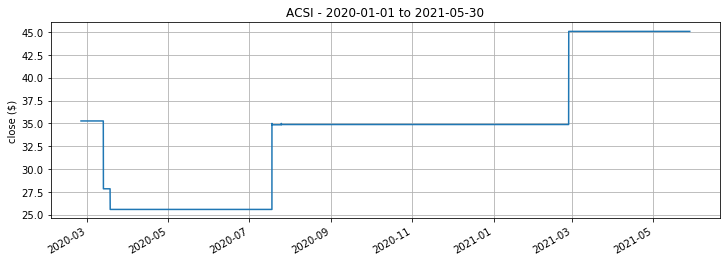

AHT


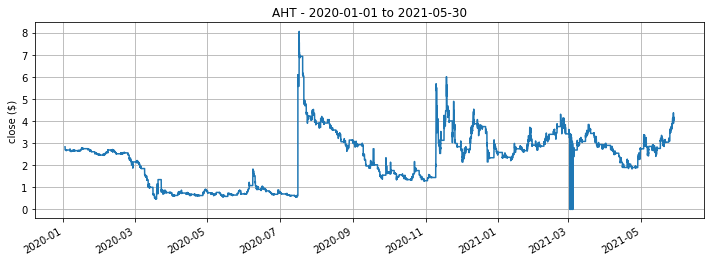

AROC


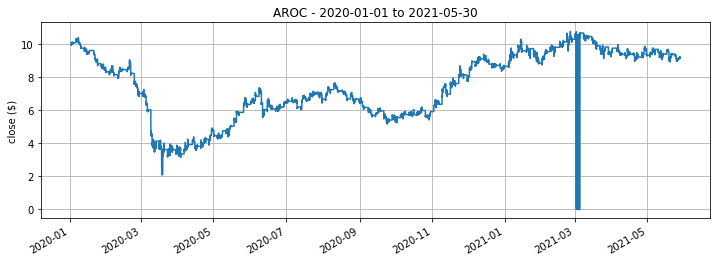

BBUS


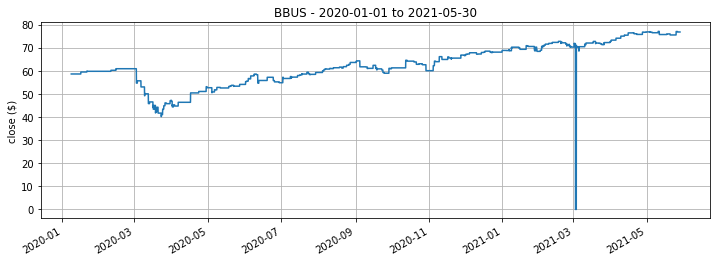

CAT


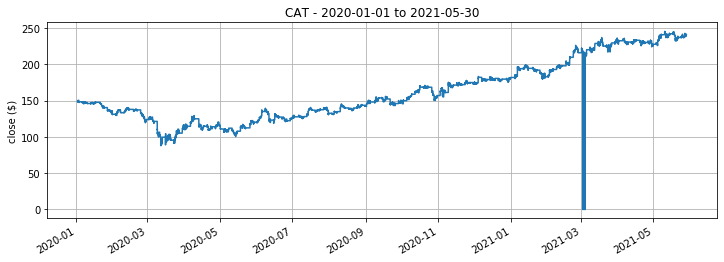

TMAT


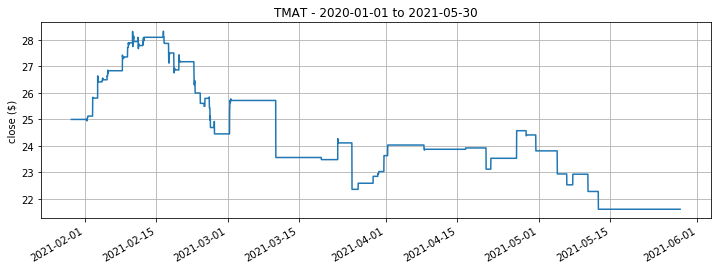

In [69]:
for symbol in df.index.levels[0].unique():
    df.loc[idx[symbol], 'close'].plot(figsize=(12,4), grid='both')
    plt.ylabel('close ($)')
    plt.title(f'{symbol} - {start_date} to {end_date}')
    print(symbol)
    plt.show()

In [68]:
df.tail()

open   high    low  close  volume
TMAT 2021-05-28 14:45:00-04:00  21.61  21.61  21.61  21.61     0.0
     2021-05-28 15:00:00-04:00  21.61  21.61  21.61  21.61     0.0
     2021-05-28 15:15:00-04:00  21.61  21.61  21.61  21.61     0.0
     2021-05-28 15:30:00-04:00  21.61  21.61  21.61  21.61     0.0
     2021-05-28 15:45:00-04:00  21.61  21.61  21.61  21.61     0.0

#### How many rows of a reindexed time series are NaN?

In [71]:
# df.loc[idx['ACSI',:]].reindex(datetime_idx_complete).isna().sum(axis=1).value_counts()
df.loc[idx[symbols_by_close_count[0],:]].reindex(datetime_idx_complete).isna().sum(axis=1).value_counts().head(6)

0    43965
4     5209
dtype: int64

### Slice df to market hours only

In [72]:
def slice_to_market_hours(df, market_open, market_close):
    from_ = market_open.strftime("%H:%M")
    to_ = market_close.strftime("%H:%M")
    idxs = df.index.get_level_values(1).indexer_between_time(from_, to_)
    return df.iloc[idxs]

In [73]:
display(df.shape)
df_mkt_hours = slice_to_market_hours(df, market_open, market_close)
df_mkt_hours.shape

(295044, 5)

(80028, 5)

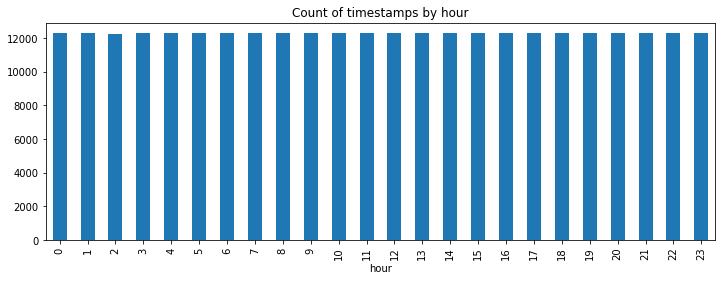

In [79]:
df.index.get_level_values(1).hour.value_counts().sort_index().plot(kind='bar', figsize=(12,4))
plt.xlabel('hour')
plt.title('Count of timestamps by hour')
plt.ylim()
plt.show()

In [89]:
df.index.get_level_values(1).hour.value_counts().quantile([0.005,1])

0.005    12245.52
1.000    12312.00
dtype: float64

In [95]:
df.index.get_level_values(1).hour.value_counts().agg([min,max]).values * [0.9,1.05]

array([11016. , 13543.2])

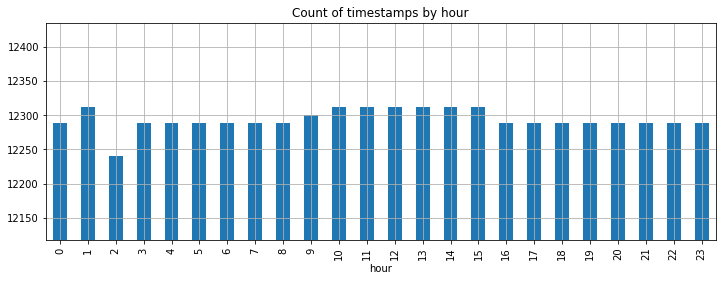

In [99]:
ax = df.index.get_level_values(1).hour.value_counts().sort_index().plot(kind='bar', figsize=(12,4), grid='y')
plt.xlabel('hour')
plt.title('Count of timestamps by hour')
y_min, y_max = df.index.get_level_values(1).hour.value_counts().agg([min,max]).values * [0.99,1.01]
plt.ylim(y_min, y_max)
plt.show()

In [100]:
df_mkt_hours.index.get_level_values(1).hour.value_counts().sort_index()

9      6156
10    12312
11    12312
12    12312
13    12312
14    12312
15    12312
dtype: int64

In [213]:
df_mkt_hours.sample(10)

open      high       low   close  volume
AHT  2020-09-05 12:15:00-04:00    2.9700    2.9700    2.9300    2.93     0.0
BBUS 2021-04-28 11:15:00-04:00   76.7700   76.7700   76.7700   76.77     0.0
AHT  2020-04-27 09:45:00-04:00    0.6335    0.6335    0.6277    0.63     0.0
     2021-05-27 10:30:00-04:00    3.8500    3.8600    3.8200    3.85  7528.0
BBUS 2020-12-08 15:15:00-05:00   67.8300   67.8300   67.8300   67.83     0.0
CAT  2021-01-31 12:45:00-05:00  183.2700  183.2700  183.0600  183.06     0.0
ACSI 2020-02-10 13:45:00-05:00       NaN       NaN       NaN     NaN     0.0
     2020-06-27 12:15:00-04:00   25.5800   25.5800   25.5800   25.58     0.0
CAT  2020-12-26 12:45:00-05:00  179.1000  179.7400  179.0800  179.74     0.0
AROC 2020-05-30 13:00:00-04:00    6.2900    6.4100    6.2900    6.36     0.0

ACSI


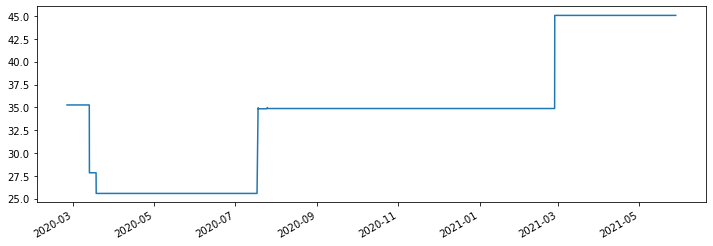

AHT


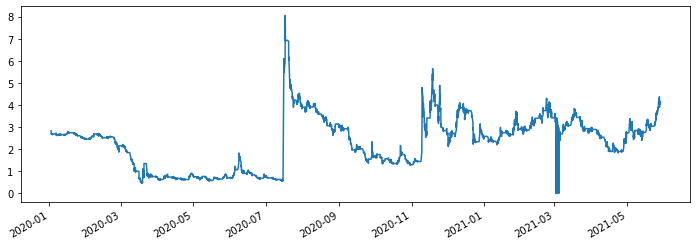

AROC


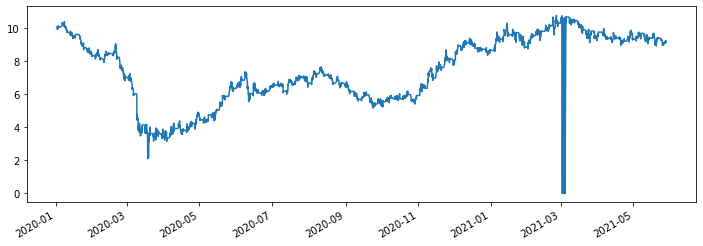

BBUS


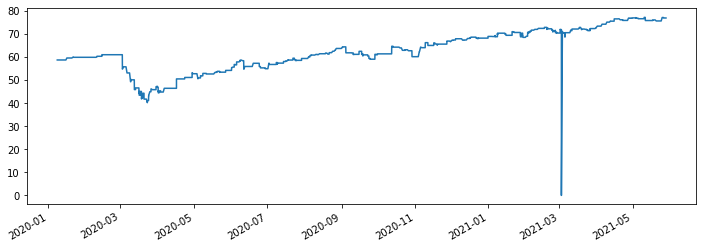

CAT


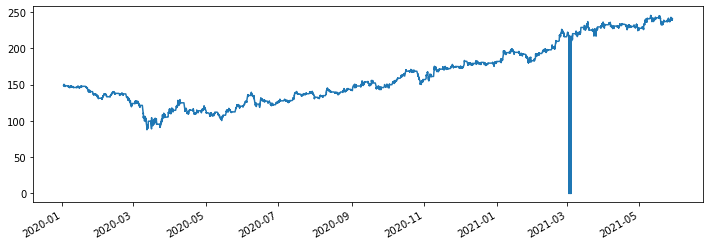

TMAT


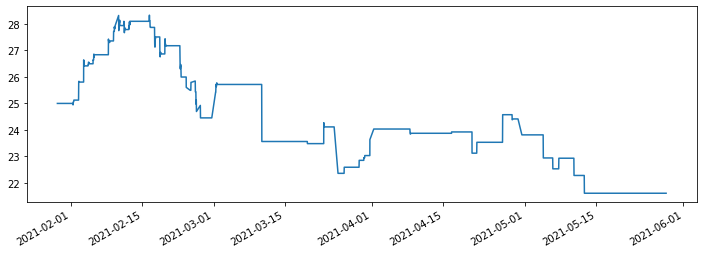

In [209]:
for symbol in df_mkt_hours.index.levels[0].unique():
    df_mkt_hours.loc[idx[symbol], 'close'].plot(figsize=(12,4))
    print(symbol)
    plt.show()

In [210]:
# for symbol in df.index.levels[0].unique():
#     df.loc[idx[symbol], 'close'].plot(figsize=(12,4))
#     print(symbol)
#     plt.show()

### Slice df to market days only

In [228]:
def infer_market_days(df, n_symbols=10):
    """Distinguish market days from non-market (market closed days) based on daily volumes.
    Daily mean volumes are divided in to a number of bins that is equal to the number of weeks
    in the data.  The upper edge of the lowest volume bin is used to define the threshold between 
    active market volume and a closed market.

    Function is intended for multi-index dfs with data from the same market.  Do not use
    for a mix of markets.   The more symbols with more volume in the df, the more reliable
    the result.  It is assumed that all symbols in df are in the same market/exchange and
    all follow the same 'market open' dates and times"""
    from numpy import histogram
    idx = pd.IndexSlice
    #     Slice df to a subset of n_symbols.  Sort symbols by count of non-NaN records and select
    # the top n_symbols by valid record count
    n_symbols = min(n_symbols,len(df.index.get_level_values(0).unique()))
    top_n_symbols = df.groupby(level=0)['open'].count()\
                    .sort_values(ascending=False).index.tolist()[:n_symbols]
    #     want to identify days where market is closed, (including holidays) so resample to days
    df_daily_volume = df.loc[idx[top_n_symbols,:], 'volume'].resample('D', level=1).mean()
    n_weeks = df_daily_volume.shape[0]//7
    hist_ = histogram(df_daily_volume, bins=n_weeks)
    #     This is the right hand edge of the first histogram bin
    volume_threshold = hist_[1][1]
    # identify days with volume > volume_threshold as market_open_days
    volume_GT_threshold = df_daily_volume > volume_threshold
    market_open_days = df_daily_volume.index.date[volume_GT_threshold]
    # set up filter to reduce df to only the days in market_open_days
    # which dates are market_open_dates?
    market_open_bool = pd.Series(df.index.get_level_values(1).date).isin(market_open_days)
#     OPTIONAL:  compare output df dates to market_open_days:
# pd.Series(sorted(list(set(df_mkt.index.get_level_values(1).floor('D')\
# .date))) == market_open_days).value_counts()
    return df.loc[idx[market_open_bool.values,:]]

In [229]:
%%time
display(df_mkt_hours.shape)
df_mkt = infer_market_days(df_mkt_hours)
df_mkt.shape

(80028, 5)

Wall time: 1.08 s


(55380, 5)

In [230]:
df_mkt.sample(10)

open    high      low    close  volume
CAT  2020-06-29 09:30:00-04:00  123.710  124.92  123.550  124.790  3141.0
     2021-03-18 13:00:00-04:00  233.300  233.65  233.230  233.520  3787.0
     2021-04-05 13:15:00-04:00  234.180  234.51  234.180  234.260  1005.0
AROC 2020-06-24 14:15:00-04:00    6.125    6.13    6.110    6.130  4730.0
TMAT 2021-03-02 15:30:00-05:00   25.800   25.84   25.710   25.710     0.0
     2020-07-29 13:45:00-04:00      NaN     NaN      NaN      NaN     0.0
ACSI 2020-03-02 13:15:00-05:00   35.270   35.27   35.270   35.270     0.0
     2020-04-28 09:45:00-04:00   25.580   25.58   25.580   25.580     0.0
AROC 2021-01-20 14:00:00-05:00    9.685    9.71    9.665    9.665  1120.0
     2020-09-16 14:45:00-04:00    6.100    6.11    6.090    6.090   900.0

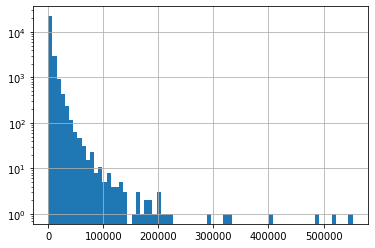

In [233]:
df_mkt.loc[df_mkt['volume']>0, 'volume'].hist(bins=73)
plt.yscale('log')
plt.show()

ACSI


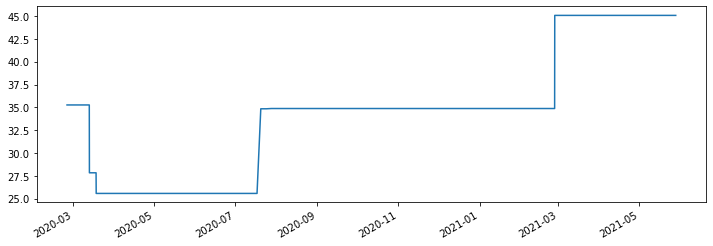

AHT


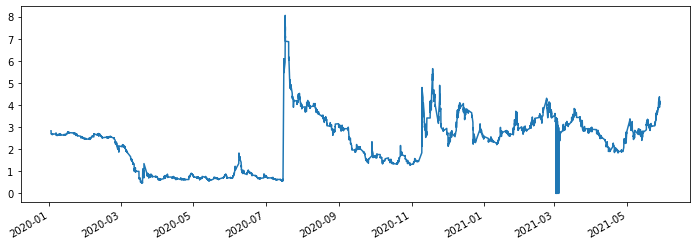

AROC


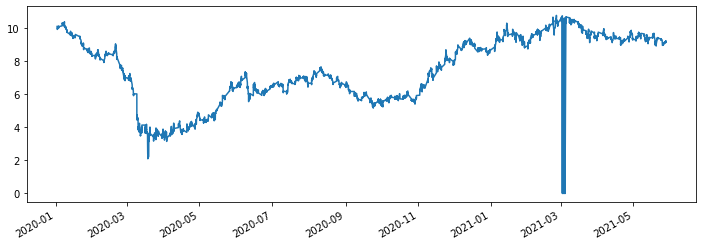

BBUS


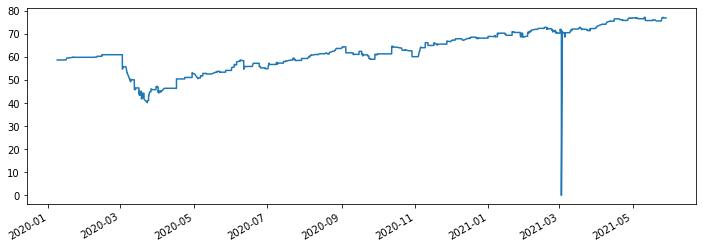

CAT


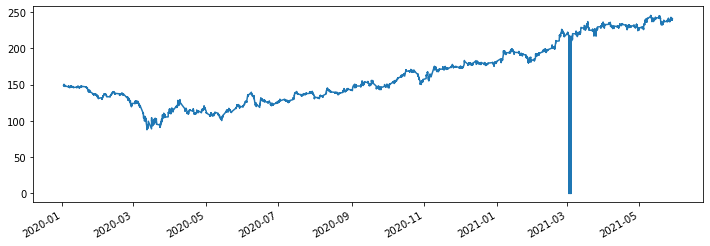

TMAT


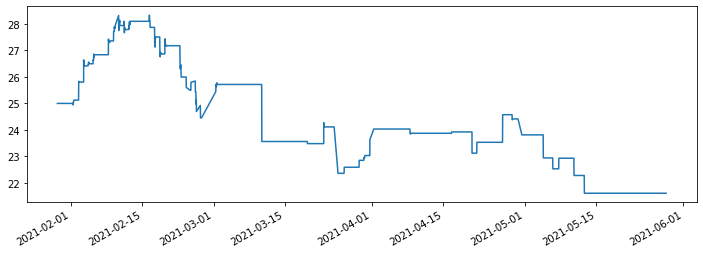

In [234]:
for symbol in df_mkt.index.levels[0].unique():
    df_mkt.loc[idx[symbol], 'close'].plot(figsize=(12,4))
    print(symbol)
    plt.show()

## Filter Noise in Data
Remember that noise filtering steps will also need to be applied to incoming data in live strategies.  For this reason, the approach here is to correct only blatant extreme values.  Otherwise noise will be left in the data.

### Correct time series data where OHLC = 0

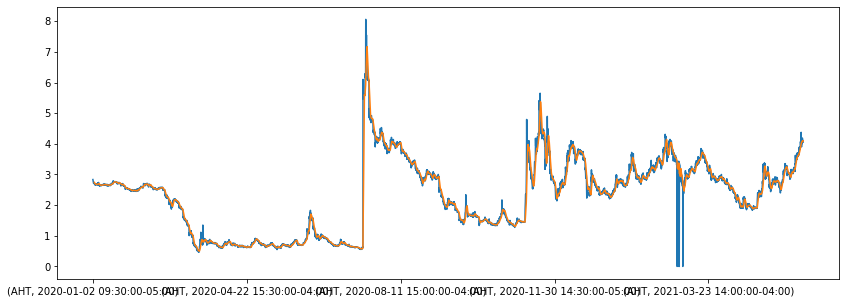

In [260]:
plt.figure(figsize=(14,5))
df_mkt.loc[idx['AHT',:],'close'].plot()
df_mkt.loc[idx['AHT',:],'close'].rolling(20).mean().plot()
plt.show()

In [252]:
# (df_mkt.loc[idx['AHT',:]] == 0).any(1)
OHLC_cols = ['open','high','low','close']
# df_mkt.loc[idx['AHT',:]].loc[(df_mkt.loc[idx['AHT',:],OHLC_cols] == 0).any(1).values]
df_mkt.loc[idx['AHT',:]].loc[(df_mkt.loc[idx['AHT',:],'close'] == 0).values]

open   high  low  close  volume
2021-03-02 09:45:00-05:00  3.325  3.340  0.0    0.0  2415.0
2021-03-02 15:30:00-05:00  3.395  3.405  0.0    0.0  1309.0
2021-03-03 10:00:00-05:00  3.375  3.370  0.0    0.0   358.0
2021-03-04 15:00:00-05:00  2.790  2.790  0.0    0.0  9806.0

In [ ]:
# df['median']= df['b'].rolling(window).median()
# df['std'] = df['b'].rolling(window).std()

# #filter setup
# df = df[(df.b <= df['median']+3*df['std']) & (df.b >= df['median']-3*df['std'])]

### Check volume data

In [235]:
df_daily = df.resample('D', level=1).mean()
df_daily

open       high        low      close  \
2020-01-02 00:00:00-05:00  54.039971  54.219397  54.015287  54.195023   
2020-01-03 00:00:00-05:00  53.862917  54.021354  53.818177  53.988785   
2020-01-04 00:00:00-05:00  53.690000  53.783333  53.610000  53.746667   
2020-01-05 00:00:00-05:00  53.690000  53.783333  53.610000  53.746667   
2020-01-06 00:00:00-05:00  53.645226  53.748073  53.595278  53.699184   
...                              ...        ...        ...        ...   
2021-05-24 00:00:00-04:00  65.494410  65.544427  65.446398  65.466580   
2021-05-25 00:00:00-04:00  65.694809  65.723611  65.615781  65.668724   
2021-05-26 00:00:00-04:00  65.643411  65.661198  65.558281  65.623151   
2021-05-27 00:00:00-04:00  66.040043  66.088290  66.000295  66.047370   
2021-05-28 00:00:00-04:00  66.296901  66.359883  66.262643  66.305781   

                                volume  
2020-01-02 00:00:00-05:00   779.114943  
2020-01-03 00:00:00-05:00   419.512153  
2020-01-04 00:00:00-05:00     0.000000  
2020-01-05 00:00:00-05:00     0.000000  
2020-01-06 00:00:00-05:00   438.446181  
...                                ...  
2021-05-24 00:00:00-04:00   387.987847  
2021-05-25 00:00:00-04:00  1107.375000  
2021-05-26 00:00:00-04:00   574.354167  
2021-05-27 00:00:00-04:00   646.763889  
2021-05-28 00:00:00-04:00   976.111979  

[513 rows x 5 columns]

In [236]:
df_daily['vol_div_by_99_pct'] = df_daily['volume']/df_daily['volume'].quantile(0.99)
# df_daily.groupby(df_daily.index.weekday)['vol_div_by_99_pct'].mean()
df_daily['vol_div_by_99_pct']

2020-01-02 00:00:00-05:00    0.398895
2020-01-03 00:00:00-05:00    0.214784
2020-01-04 00:00:00-05:00    0.000000
2020-01-05 00:00:00-05:00    0.000000
2020-01-06 00:00:00-05:00    0.224478
                               ...   
2021-05-24 00:00:00-04:00    0.198644
2021-05-25 00:00:00-04:00    0.566960
2021-05-26 00:00:00-04:00    0.294061
2021-05-27 00:00:00-04:00    0.331134
2021-05-28 00:00:00-04:00    0.499755
Freq: D, Name: vol_div_by_99_pct, Length: 513, dtype: float64

In [237]:
df_daily['vol_div_by_99_pct'].quantile([0.05,0.1,0.15,0.25, 0.8])

0.05    0.000000
0.10    0.000000
0.15    0.000000
0.25    0.000000
0.80    0.413151
Name: vol_div_by_99_pct, dtype: float64

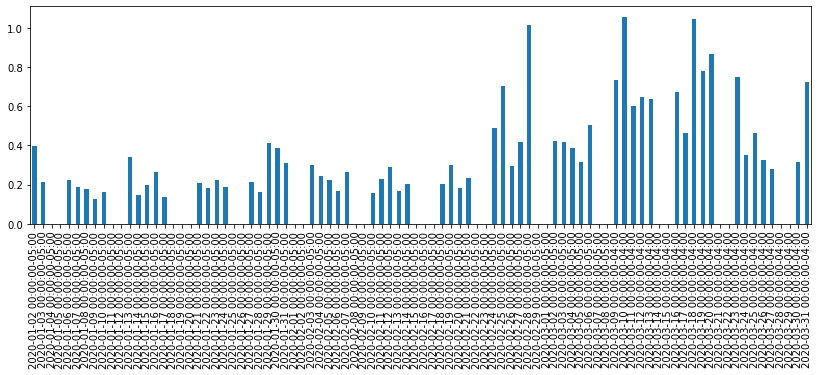

In [238]:
df_daily['vol_div_by_99_pct'][:90].plot(kind='bar', figsize=(14,4))

In [161]:
from numpy import arange, histogram

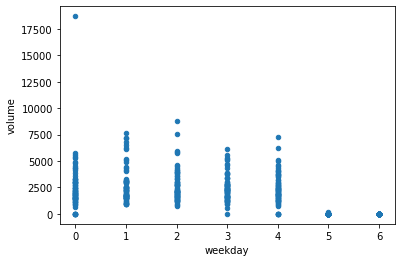

In [126]:
df_daily.assign(weekday = df_daily.index.weekday).plot(kind='scatter', x='weekday',y='volume')

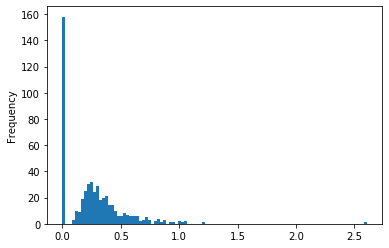

In [119]:
(df_daily['volume']/df_daily['volume'].quantile(0.99)).plot(kind='hist', bins=100)

# NOTES

In [17]:
def remove_incomplete_symbols(min_threshold_pct=20):
    """Return multi-index df where all symbols whose history has data for less
    than the min_threshold_pct is omitted"""

### Visualize data

In [71]:
import matplotlib as mpl

In [93]:
# df.loc[idx[assets_query[0],:]].groupby(pd.Grouper(freq='1Min'))
df.loc[idx[assets_query[0],:]].groupby(pd.Grouper(freq='1D')).agg({'open' : 'mean', 'high': 'mean','low': 'mean','close': 'mean','volume':'sum'})
# .groupby(pd.Grouper(freq=freq,level=1)).agg({'open' : 'mean', 'high': 'mean','low': 'mean','close': 'mean','volume':'sum'})

open        high         low       close  \
timestamp                                                                   
2020-01-02 00:00:00-05:00  158.539452  158.608411  158.489110  158.556027   
2020-01-03 00:00:00-05:00  158.595972  158.686458  158.561944  158.642986   
2020-01-04 00:00:00-05:00         NaN         NaN         NaN         NaN   
2020-01-05 00:00:00-05:00         NaN         NaN         NaN         NaN   
2020-01-06 00:00:00-05:00  156.984839  157.044839  156.948226  157.007339   
...                               ...         ...         ...         ...   
2021-05-20 00:00:00-04:00  196.369714  196.480429  196.242357  196.365857   
2021-05-21 00:00:00-04:00  195.496736  195.562431  195.404097  195.472083   
2021-05-22 00:00:00-04:00         NaN         NaN         NaN         NaN   
2021-05-23 00:00:00-04:00         NaN         NaN         NaN         NaN   
2021-05-24 00:00:00-04:00  192.598910  192.676282  192.472756  192.559359   

                           volume  
timestamp                          
2020-01-02 00:00:00-05:00   65291  
2020-01-03 00:00:00-05:00   46873  
2020-01-04 00:00:00-05:00  212948  
2020-01-05 00:00:00-05:00  119722  
2020-01-06 00:00:00-05:00   44049  
...                           ...  
2021-05-20 00:00:00-04:00   66345  
2021-05-21 00:00:00-04:00   48734  
2021-05-22 00:00:00-04:00  285333  
2021-05-23 00:00:00-04:00  154119  
2021-05-24 00:00:00-04:00   98092  

[509 rows x 5 columns]

In [116]:
def price_volume(df, price='open', vol='volume', symbol=assets_query[0], freq='1Hour',fname=None):
    # for multiindex:
    idx = pd.IndexSlice
    df = df.loc[idx[symbol,:]].groupby(pd.Grouper(freq=freq)).agg({'open' : 'mean',
                                                'high': 'mean',
                                                'low': 'mean',
                                                'close': 'mean',
                                                'volume':'sum'})
    
#     df = df.groupby(pd.Grouper(freq=freq)).agg({'open' : 'mean',
#                                                 'high': 'mean',
#                                                 'low': 'mean',
#                                                 'close': 'mean',
#                                                 'volume':'sum'})
#     df.fillna(method='ffill', inplace=True)
    
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(15,8))
    axes[0].plot(df.index, df[price])
    axes[1].bar(df.index, df[vol], width=1/(5*len(df.index)), color='r')
    
    # formatting
    xfmt = mpl.dates.DateFormatter('%H:%M')
    axes[1].xaxis.set_major_locator(mpl.dates.HourLocator(interval=3))
#     axes[1].xaxis.set_major_formatter(xfmt)
#     axes[1].get_xaxis().set_tick_params(which='major', pad=25)
    axes[0].set_title(f'{price}', fontsize=14)
    axes[1].set_title('Volume', fontsize=14)
#     fig.autofmt_xdate()
    fig.suptitle(symbol)
#     fig.tight_layout()
#     plt.subplots_adjust(top=0.9);

In [117]:
price_volume(df, freq='1D')

RuntimeError: Locator attempting to generate 4470 ticks from 737400.9166666666 to 737959.5416666666: exceeds Locator.MAXTICKS

In [107]:
df.loc[idx[assets_query[0],:]].groupby(pd.Grouper(freq='1D')).agg({'open' : 'mean', 'high': 'mean','low': 'mean','close': 'mean','volume':'sum'}).describe()

open        high         low       close        volume
count  352.000000  352.000000  352.000000  352.000000  5.090000e+02
mean   150.988843  150.894529  149.788273  150.424849  1.493162e+05
std     24.746530   24.706812   26.845538   25.201401  1.768936e+05
min     76.246883   76.524805   30.278052   76.184416  7.800000e+03
25%    139.339406  139.091846  137.970374  138.244302  5.317100e+04
50%    152.354036  151.972041  151.814058  151.914984  8.779400e+04
75%    159.970142  159.761562  159.594894  159.695703  1.759340e+05
max    208.749225  208.832042  208.681972  208.749718  1.668435e+06

In [90]:
def get_bar_stats(agg_trades, weighted_price='close'):
#     vwap = agg_trades.apply(lambda x: np.average(x[weighted_price], weights=x.volume)).to_frame('vwap')
#     ohlc = agg_trades.price.ohlc()
    vol = agg_trades.shares.sum().to_frame('vol')
#     txn = agg_trades.shares.size().to_frame('txn')
    return pd.concat([ohlc, vwap, vol, txn], axis=1)

In [91]:
df.loc[idx[assets_query[0],:],].droplevel(0)

open     high      low    close  volume
timestamp                                                            
2020-01-02 09:30:00-05:00  160.115  160.540  160.110  160.540    1712
2020-01-02 09:35:00-05:00  160.435  160.890  160.420  160.610    1187
2020-01-02 09:40:00-05:00  160.780  160.860  160.470  160.860     884
2020-01-02 09:45:00-05:00  160.900  160.900  160.900  160.900     288
2020-01-02 09:50:00-05:00  160.230  160.230  160.115  160.115     743
...                            ...      ...      ...      ...     ...
2021-05-24 15:35:00-04:00  191.220  191.220  190.975  191.040    4624
2021-05-24 15:40:00-04:00  191.020  191.150  190.760  190.880    6276
2021-05-24 15:45:00-04:00  190.885  190.925  190.690  190.720    4627
2021-05-24 15:50:00-04:00  190.760  190.840  190.700  190.710    7669
2021-05-24 15:55:00-04:00  190.720  190.770  190.540  190.610    6691

[39726 rows x 5 columns]

In [92]:
import numpy as np
trades = df.loc[idx[assets_query[0],:],].droplevel(0)
resampled = trades.groupby(pd.Grouper(freq='1H'))
time_bars = get_bar_stats(resampled)
# normaltest(time_bars.vwap.pct_change().dropna())

AttributeError: 'DataFrameGroupBy' object has no attribute 'shares'

In [ ]:
price_volume(time_bars, 
             suptitle=f'Time Bars | {stock} | {pd.to_datetime(date).date()}', 
             fname='time_bars')

In [29]:
import bokeh
bokeh.sampledata.download()

Creating C:\Users\user\.bokeh directory
Creating C:\Users\user\.bokeh\data directory
Using data directory: C:\Users\user\.bokeh\data
Downloading: CGM.csv (1589982 bytes)
   1589982 [100.00%]
Downloading: US_Counties.zip (3171836 bytes)
   3171836 [100.00%]
Unpacking: US_Counties.csv
Downloading: us_cities.json (713565 bytes)
    713565 [100.00%]
Downloading: unemployment09.csv (253301 bytes)
    253301 [100.00%]
Downloading: AAPL.csv (166698 bytes)
    166698 [100.00%]
Downloading: FB.csv (9706 bytes)
      9706 [100.00%]
Downloading: GOOG.csv (113894 bytes)
    113894 [100.00%]
Downloading: IBM.csv (165625 bytes)
    165625 [100.00%]
Downloading: MSFT.csv (161614 bytes)
    161614 [100.00%]
Downloading: WPP2012_SA_DB03_POPULATION_QUINQUENNIAL.zip (4816256 bytes)
   4816256 [100.00%]
Unpacking: WPP2012_SA_DB03_POPULATION_QUINQUENNIAL.csv
Downloading: gapminder_fertility.csv (64346 bytes)
     64346 [100.00%]
Downloading: gapminder_population.csv (94509 bytes)
     94509 [100.00%]
Downl

In [33]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import gridplot
from bokeh.sampledata.stocks import MSFT
output_notebook()
MSFT = pd.DataFrame(MSFT)[:50]
#     df["date"] = pd.to_datetime(df["date"])
MSFT.head()

Loading BokehJS ...

date   open   high    low  close     volume  adj_close
0  2000-03-01  89.62  94.09  88.94  90.81  106889800      33.68
1  2000-03-02  91.81  95.37  91.12  93.37  106932600      34.63
2  2000-03-03  94.75  98.87  93.87  96.12  101435200      35.65
3  2000-03-06  96.00  97.37  90.12  90.62   93609400      33.61
4  2000-03-07  96.12  97.50  91.94  92.87  135061000      34.45

In [34]:
pd.to_datetime(MSFT['date'])

0    2000-03-01
1    2000-03-02
2    2000-03-03
3    2000-03-06
4    2000-03-07
5    2000-03-08
6    2000-03-09
7    2000-03-10
8    2000-03-13
9    2000-03-14
10   2000-03-15
11   2000-03-16
12   2000-03-17
13   2000-03-20
14   2000-03-21
15   2000-03-22
16   2000-03-23
17   2000-03-24
18   2000-03-27
19   2000-03-28
20   2000-03-29
21   2000-03-30
22   2000-03-31
23   2000-04-03
24   2000-04-04
25   2000-04-05
26   2000-04-06
27   2000-04-07
28   2000-04-10
29   2000-04-11
30   2000-04-12
31   2000-04-13
32   2000-04-14
33   2000-04-17
34   2000-04-18
35   2000-04-19
36   2000-04-20
37   2000-04-24
38   2000-04-25
39   2000-04-26
40   2000-04-27
41   2000-04-28
42   2000-05-01
43   2000-05-02
44   2000-05-03
45   2000-05-04
46   2000-05-05
47   2000-05-08
48   2000-05-09
49   2000-05-10
Name: date, dtype: datetime64[ns]

In [54]:
df.loc[idx[assets_query[0],:]].head(2)

open    high     low   close  volume
timestamp                                                         
2020-01-02 09:30:00-05:00  160.115  160.54  160.11  160.54    1712
2020-01-02 09:35:00-05:00  160.435  160.89  160.42  160.61    1187

In [51]:
df.loc[idx[assets_query[0],:]].index.strftime("%Y-%m-%d")

Index(['2020-01-02', '2020-01-02', '2020-01-02', '2020-01-02', '2020-01-02',
       '2020-01-02', '2020-01-02', '2020-01-02', '2020-01-02', '2020-01-02',
       ...
       '2021-05-24', '2021-05-24', '2021-05-24', '2021-05-24', '2021-05-24',
       '2021-05-24', '2021-05-24', '2021-05-24', '2021-05-24', '2021-05-24'],
      dtype='object', name='timestamp', length=39726)

In [45]:
df.loc[idx[assets_query[0],:]].isna()

open      15620
high      15620
low       15620
close     15620
volume        0
dtype: int64

In [67]:

def candlestick_w_volume(df, symbol):
    """Plot OHLC Candlestick with Volume chart"""
    from math import pi
#     import pandas as pd
    from bokeh.plotting import figure, output_notebook, show
    from bokeh.layouts import gridplot
    from bokeh.sampledata.stocks import MSFT
    output_notebook()
#     df = pd.DataFrame(MSFT)[:50]
#     df["date"] = pd.to_datetime(df["date"]) - Original Code
# for multiindex:
    df = df.loc[idx[symbol,:]]
    
    df["date"] = df.index.strftime("%Y-%m-%d")
    display(df.head(2))
    

    inc = df.close > df.open
    dec = df.open > df.close
    w = 12*60*60*1000 # half day in ms
    print(inc, dec)

    TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

    p1 = figure(x_axis_type="datetime", tools=TOOLS, plot_width=700, plot_height=300, title = f"{symbol}")
    p1.xaxis.visible = False
    p1.xaxis.major_label_orientation = pi/4
    p1.grid.grid_line_alpha=0.3
    print(p1.x_range)
    
    p1.segment(df.date, df.high, df.date, df.low, color="black")
    p1.vbar(df.date[inc], w, df.open[inc], df.close[inc], fill_color="#D5E1DD", line_color="black")
    p1.vbar(df.date[dec], w, df.open[dec], df.close[dec], fill_color="#F2583E", line_color="black")

    p2 = figure(x_axis_type="datetime", tools="", toolbar_location=None, plot_width=700, plot_height=200, x_range=p1.x_range)
    p2.xaxis.major_label_orientation = pi/4
    p2.grid.grid_line_alpha=0.3
    p2.vbar(df.date, w, df.volume, [0]*df.shape[0])

    show(gridplot([[p1],[p2]]))

In [68]:
candlestick_w_volume(df, assets_query[0])

Loading BokehJS ...

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


open    high     low   close  volume        date
timestamp                                                                     
2020-01-02 09:30:00-05:00  160.115  160.54  160.11  160.54    1712  2020-01-02
2020-01-02 09:35:00-05:00  160.435  160.89  160.42  160.61    1187  2020-01-02

timestamp
2020-01-02 09:30:00-05:00     True
2020-01-02 09:35:00-05:00     True
2020-01-02 09:40:00-05:00     True
2020-01-02 09:45:00-05:00    False
2020-01-02 09:50:00-05:00    False
                             ...  
2021-05-24 15:35:00-04:00    False
2021-05-24 15:40:00-04:00    False
2021-05-24 15:45:00-04:00    False
2021-05-24 15:50:00-04:00    False
2021-05-24 15:55:00-04:00    False
Length: 39726, dtype: bool timestamp
2020-01-02 09:30:00-05:00    False
2020-01-02 09:35:00-05:00    False
2020-01-02 09:40:00-05:00    False
2020-01-02 09:45:00-05:00    False
2020-01-02 09:50:00-05:00     True
                             ...  
2021-05-24 15:35:00-04:00     True
2021-05-24 15:40:00-04:00     True
2021-05-24 15:45:00-04:00     True
2021-05-24 15:50:00-04:00     True
2021-05-24 15:55:00-04:00     True
Length: 39726, dtype: bool
DataRange1d(id='3543', ...)


In [30]:
def candlestick_w_volume():
    """Plot OHLC Candlestick with Volume chart"""
    from math import pi

    import pandas as pd

    from bokeh.plotting import figure, output_notebook, show
    from bokeh.layouts import gridplot
    from bokeh.sampledata.stocks import MSFT

    output_notebook()

    df = pd.DataFrame(MSFT)[:50]
    df["date"] = pd.to_datetime(df["date"])

    inc = df.close > df.open
    dec = df.open > df.close
    w = 12*60*60*1000 # half day in ms

    TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

    p1 = figure(x_axis_type="datetime", tools=TOOLS, plot_width=700, plot_height=300, title = "MSFT Candlestick with Volume")
    p1.xaxis.visible = False
    p1.xaxis.major_label_orientation = pi/4
    p1.grid.grid_line_alpha=0.3

    p1.segment(df.date, df.high, df.date, df.low, color="black")
    p1.vbar(df.date[inc], w, df.open[inc], df.close[inc], fill_color="#D5E1DD", line_color="black")
    p1.vbar(df.date[dec], w, df.open[dec], df.close[dec], fill_color="#F2583E", line_color="black")

    p2 = figure(x_axis_type="datetime", tools="", toolbar_location=None, plot_width=700, plot_height=200, x_range=p1.x_range)
    p2.xaxis.major_label_orientation = pi/4
    p2.grid.grid_line_alpha=0.3
    p2.vbar(df.date, w, df.volume, [0]*df.shape[0])

    show(gridplot([[p1],[p2]]))

In [31]:
candlestick_w_volume()

Loading BokehJS ...

### Save df to disk

In [15]:
def multi_symbol_df_to_csv(df, directory=''):
    start_date = datetime.strftime(df.index.get_level_values(1).min(),"%Y-%m-%d")
    end_date = datetime.strftime(df.index.get_level_values(1).max(),"%Y-%m-%d")
    n_symbols = df.index.get_level_values(0).nunique()
    frequency = df.index.levels[1].freqstr
    filename = os.path.join(directory,f'symbols_{n_symbols}_{frequency}_{start_date} to {end_date}.csv') 
    df.to_csv(filename)
    print(f'df saved as "{filename}"')

In [84]:
multi_symbol_df_to_csv(df, directory='data')

df saved as "data\symbols_6_15T_2020-01-02 to 2021-05-24.csv"


## Add Technical indicators
normalized volume?

In [ ]:
import alpaca_backtrader_api
import backtrader as bt
# from datetime import datetime

# ALPACA_API_KEY = <key_id>
# ALPACA_SECRET_KEY = <secret_key>
# ALPACA_PAPER = True


class SmaCross(bt.SignalStrategy):
  def __init__(self):
    sma1, sma2 = bt.ind.SMA(period=10), bt.ind.SMA(period=30)
    crossover = bt.ind.CrossOver(sma1, sma2)
    self.signal_add(bt.SIGNAL_LONG, crossover)


cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCross)

In [ ]:
store = alpaca_backtrader_api.AlpacaStore(
#     key_id=ALPACA_API_KEY,
#     secret_key=ALPACA_SECRET_KEY,
#     paper=ALPACA_PAPER
)

In [ ]:
if not ALPACA_PAPER:
  broker = store.getbroker()  # or just alpaca_backtrader_api.AlpacaBroker()
  cerebro.setbroker(broker)

In [ ]:
DataFactory = store.getdata  # or use alpaca_backtrader_api.AlpacaData
data0 = DataFactory(dataname='AAPL', historical=True, fromdate=datetime(
    2015, 1, 1), timeframe=bt.TimeFrame.Days)
cerebro.adddata(data0)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.plot()

### Technical Indicator functions

# END